# Notebook 1: Examples of using Paicos

This script shows how to

- load data
- make projections and slices
- save them as an 'ArepoImage'
- how to convert the Arepo data from comoving code units to physical values in various unit systems


## Compilation
The first step is to compile the code, this only needs to be done the first time you use Paicos and if you have not already followed the installation instructions (replace the path to your own cloned version, you will also need to add this path to your PYTHONPATH).

In [1]:
#%%bash
#cd ~/projects/paicos
#make clean
#make

## Loading arepo snapshots

We load a zoom-in simulation of a galaxy cluster simulation below (the data is not included in the repo, so you will need to download this. See documentation)

In [3]:
import paicos as pa
import numpy as np

# A snapshot object
snap = pa.Snapshot(pa.data_dir, 247)

# The center of the most massive Friends-of-friends group in the simulation
center = snap.Cat.Group['GroupPos'][0]

## Useful metadata
We can look at some of snap attributes:

In [4]:
# Age of the Universe for the snapshot
snap.age

<PaicosQuantity 13.80223476 Gyr>

In [5]:
# The lookback time
snap.lookback_time

<PaicosQuantity 3.55271368e-15 Gyr>

In [6]:
# An astropy cosmology object (used internally to calculate the age and lookback, 
# cosmological parameters automatically loaded from the the snapshot)
snap.cosmo

LambdaCDM(H0=67.32117 km / (Mpc s), Om0=0.31582309, Ode0=0.68417691, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.04938682)

In [7]:
# The size of the computational box
snap.box_size.to('Mpc').to_physical

<PaicosQuantity [1485.41704731, 1485.41704731, 1485.41704731] Mpc>

In [8]:
# The redshift
snap.z

2.220446049250313e-16

In [9]:
# Adiabatic index used in the simulation
snap.gamma

1.6666666666666667

In [10]:
# Contents of the three hdf5 groups containing information about the snapshot (uncomment to see output)
#snap.Header
#snap.Parameters
#snap.Config

## Loading of data blocks
Loading of data can be done using function calls or by trying to access them explicitly.
Here we load the Arepo data as a PaicosQuantity (basically a subclass of an astropy quantity), which gives the numeric data units and some useful methods. The numeric values are the same as stored in the hdf5 files but we can now see the units used in the simulation. Here small_h and small_a are the reduced Hubble parameter and the scale factor, respectively. 

In [11]:
# Load some variables from the PartType 0 (gas variables) 

# You can explicitly load using function call:
snap.load_data(0, 'Coordinates')
snap['0_Coordinates']

# But is much easier to just do it like this:
snap['0_Density']
snap['0_MagneticField']

# snap
snap['0_Volume']

Attempting to get derived variable: 0_Volume...	[DONE]



<PaicosQuantity [1.13548299e+03, 1.25744406e+03, 1.50093613e+03, ...,
                 8.87195460e+07, 6.21206842e+08, 7.11135763e+07] arepo_mass small_a3 / (arepo_density small_h3)>

In [12]:
# The available fields for a PartType can be found as shown below for parttype 0 (the gas)
keys = snap.info(0)

# alternatively, by starting to type and using tab-completion, i.e., snap['0_  and then hit tab


Keys for PartType0 in the hdf5 file:
0_AllowRefinement
0_CenterOfMass
0_Coordinates
0_Density
0_ElectronAbundance
0_EnergyDissipation
0_GFM_AGNRadiation
0_GFM_CoolingRate
0_GFM_Metallicity
0_GFM_Metals
0_GFM_WindDMVelDisp
0_GFM_WindHostHaloMass
0_HighResGasMass
0_InternalEnergy
0_Machnumber
0_MagneticField
0_MagneticFieldDivergence
0_MagneticFieldDivergenceAlternative
0_Masses
0_NeutralHydrogenAbundance
0_ParticleIDs
0_Potential
0_StarFormationRate
0_SubfindDMDensity
0_SubfindDensity
0_SubfindHsml
0_SubfindVelDisp
0_Velocities
0_VelocityGradient

Possible derived variables are:
0_Diameters
0_Enstrophy
0_EnstrophyTimesMasses
0_GFM_MetallicityTimesMasses
0_MachnumberTimesEnergyDissipation
0_MagneticFieldSquared
0_MagneticFieldSquaredTimesVolume
0_MagneticFieldStrength
0_MeanMolecularWeight
0_NumberDensity
0_Pressure
0_PressureTimesVolume
0_Temperatures
0_TemperaturesTimesMasses
0_VelocityCurvature
0_VelocityMagnitude
0_Volume


## Unit conversion 
Here we show how to use convert the density field to various useful physical units and
how to get rid of the a and h factors used in cosmological simulations with Arepo.

In [13]:
# Unit conversion
rho = snap['0_Density']
print('rho[0] in CGS:\t', rho[0].cgs)
print('rho[0] in SI:\t', rho[0].si)
print("rho[0] in 'astro' units:\t", rho[0].astro)
print("rho[0] in Msun/au^3:\t", rho[0].to('Msun/au3'), '\n\n')

# Get rid of h factors
print('rho[0] without h:\t', rho[0].no_small_h)

# Get rid of both a and h factors
print('rho[0] without a and h:\t', rho[0].to_physical, '\n\n')

# Get a label for use in plots
print(rho.label(r'\rho'))
print(rho.astro.label(r'\rho'))

rho[0] in CGS:	 6.586066423538464e-25 g small_h2 / (cm3 small_a3)
rho[0] in SI:	 6.586066423538463e-22 kg small_h2 / (m3 small_a3)
rho[0] in 'astro' units:	 9731321.74428584 small_h2 solMass / (kpc3 small_a3)
rho[0] in Msun/au^3:	 1.1089103378991942e-18 small_h2 solMass / (AU3 small_a3) 


rho[0] without h:	 0.00044090644374425626 arepo_density / small_a3
rho[0] without a and h:	 0.00044090644374425653 arepo_density 


$\rho\;a^{-3}h^{2}\; \left[\mathrm{arepo\_density}\right]$
$\rho\;a^{-3}h^{2}\; \left[\mathrm{M_{\odot}}\;\mathrm{kpc}^{-3}\right]$


### Changing the units in a PaicosQuantity
Please note that the methods above return a new object without modifying the original data. Modification can be done by overwriting, e.g., like this:

In [14]:
rho = rho.to_physical
rho

<PaicosQuantity [4.40906444e-04, 4.11126523e-04, 3.81600963e-04, ...,
                 9.60358397e-09, 3.67888283e-10, 1.18164277e-08] arepo_density>

### Getting rid of units

The PaicosQuantity uses the astropy quantity internally, which again uses numpy arrays.
In case you are not familiar with astropy: Here is how you can access the unit and numeric values independently like this: 

In [15]:
# The unit
rho.unit

Unit("arepo_density")

In [16]:
# The numeric values (a numpy array)
rho.value

array([4.40906444e-04, 4.11126523e-04, 3.81600963e-04, ...,
       9.60358397e-09, 3.67888283e-10, 1.18164277e-08])

## Automatically computing derived variables
Here we show how Paicos can automatically compute derived variables.
Paicos gives information about what is happening under the hood

This feature can be turned off by setting

```
pa.settings.use_only_user_functions = True
```
but we note that changes to `pa.settings.use_only_user_functions` only take effect for freshly loaded snapshots.

In [17]:
# The gas cell volumes (per default Arepo only outputs the gas mass and density)
snap['0_Volume']

# The gas temperature times the cell gas mass
snap['0_TemperaturesTimesMasses']

# The gas enstrophy
snap['0_Enstrophy']

Attempting to get derived variable: 0_TemperaturesTimesMasses...
	So we need the variable: 0_Temperatures...
	So we need the variable: 0_MeanMolecularWeight...	[DONE]

Attempting to get derived variable: 0_Enstrophy...	[DONE]



<PaicosQuantity [2.05483272e+03, 3.71073260e+03, 4.08898476e+03, ...,
                 4.45839155e-01, 1.79965047e-04, 7.33761679e-02] arepo_velocity2 small_h2 / (arepo_length2 small_a)>

The console output can be turned off by setting
```
pa.settings.print_info_when_deriving_variables = False
```
This is illustrated below where no information is printed:

In [18]:
# Turn off info
pa.settings.print_info_when_deriving_variables = False

# The metallicity multiplied by the mass
snap['0_GFM_MetallicityTimesMasses']

# Turn info back on
pa.settings.print_info_when_deriving_variables = True

## Making projections

We now use the Paicos projector class, the 'widths' vector is the size of the considered box in x,y,z coordinates. This box is centered at 'center' vector.

The direction can be set to 'x', 'y' or 'z'. If the direction is 'z' (as below) then widths[2] is the depth of the projection and the 2D returned array is in the xy plane.

npix is the number of pixels in the horizontal direction of the image. The width/height ratio should be such that $$npix*height/width$$ is an integer, such that the image pixels are square.

In [19]:
# The widths of the subbox to be projected
widths = [26000, 13000, 10000]

# Create a projector object
projector = pa.Projector(snap, center, widths, 'z', npix=2048)

# Let's look at its docstring
projector?

Type:           Projector
String form:    <paicos.image_creators.projector.Projector object at 0x7f8bfc456410>
File:           ~/analysis/paicos/paicos/image_creators/projector.py
Docstring:     
A class that allows creating an image of a given variable by projecting
it onto a 2D plane.

The Projector class is a subclass of the ImageCreator class.
The Projector class creates an image of a given variable by projecting
it onto a 2D plane.

It takes in several parameters such as a snapshot object, center and
widths of the region, direction of projection, and various optional
parameters for number of pixels, smoothing length.
Init docstring:
Initialize the Projector class.

Parameters
----------
snap : Snapshot
    A snapshot object of Snapshot class from paicos package.

center : numpy array
    Center of the region on which projection is to be done, e.g.
    center = [x_c, y_c, z_c].

widths : numpy array
    Widths of the region on which projection is to be done,
    e.g.m widths=[width

### Calling project_variable
We can call the project_variable method as below. This method can take a number of standard strings (which then internally calls the get_variable function, see further details below) or it can take an array. Both methods are shown below.

In [20]:
Masses = projector.project_variable('0_Masses')
Volumes = projector.project_variable(snap['0_Volume'])
rho = Masses/Volumes

rho

<PaicosQuantity [[5.97826609e-10, 5.98904216e-10, 5.99944873e-10, ...,
                  2.74327529e-09, 2.72723099e-09, 2.70893193e-09],
                 [5.99086484e-10, 6.00146927e-10, 6.01168837e-10, ...,
                  2.75638145e-09, 2.74090042e-09, 2.72323553e-09],
                 [6.00303730e-10, 6.01347285e-10, 6.02351306e-10, ...,
                  2.76934974e-09, 2.75277902e-09, 2.73567615e-09],
                 ...,
                 [2.68398067e-09, 2.69577298e-09, 2.70587085e-09, ...,
                  1.04739363e-09, 1.04956438e-09, 1.05179782e-09],
                 [2.67791900e-09, 2.69019352e-09, 2.70069908e-09, ...,
                  1.05066476e-09, 1.05288808e-09, 1.05517628e-09],
                 [2.67089558e-09, 2.68372597e-09, 2.69470154e-09, ...,
                  1.05405620e-09, 1.05633479e-09, 1.05868058e-09]] arepo_density small_h2 / small_a3>

We can now plot the projected density

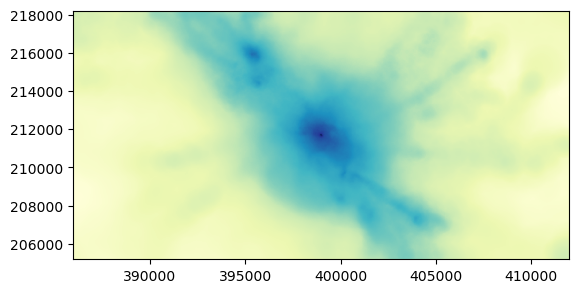

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('image', origin='lower', cmap='RdBu_r', interpolation='None')
plt.imshow(rho.value, cmap='YlGnBu', extent=projector.extent.value, norm=LogNorm())

The projector object contains a number of useful attributes with mostly self-explanatory names:

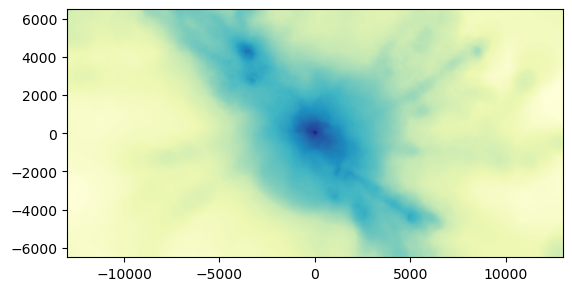

In [22]:
# Widths (same as user input)
projector.widths

# Volume of the subbox
projector.volume

# Area per pixel
projector.area_per_pixel

# Volume per pixel
projector.volume_per_pixel

# Center of the image (same as user input)
projector.center

# Depth of the projection
projector.depth

# Height of the image (i.e. along the vertical direction of the image)
projector.height

# Width of the image (i.e. along the horizontal direction of the image)
projector.width

# For use in the matplotlib argument extent
projector.extent

# For centering the image such that its center is at (0, 0).
projector.centered_extent 

# E.g. a centered image is created like this
plt.imshow(rho.value, cmap='YlGnBu', extent=projector.centered_extent.value, norm=LogNorm())


## Making slices

Next, we will take a look at making a slice through the simulation. The width is by definition zero, and the user has to set this explicitly by setting a zero in the 'widths' vector. Below we show a slice of density, comparing with the projected density.

In [23]:
widths = [26000, 13000, 0]
slicer = pa.Slicer(snap, center, widths, 'z', npix=2048)

<Figure size 640x480 with 0 Axes>

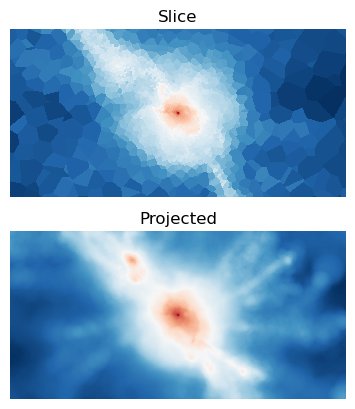

In [24]:
plt.figure(1)
plt.clf()
fix, axes = plt.subplots(nrows=2)

# Slice by passing an array
rho_slice = slicer.slice_variable(snap['0_Density'])

# Slice by passing a string (see snap.info(0) for the available strings)
rho_slice = slicer.slice_variable('0_Density')

# Now plot slice and projection next to each other
axes[0].imshow(rho_slice.to_physical.value, norm=LogNorm())
axes[1].imshow(rho.value, norm=LogNorm())
axes[0].set_title('Slice')
axes[1].set_title('Projected')
for ii in range(2):
    axes[ii].set_axis_off()
# plt.savefig('halo3_Z12_slice_projec_comparison.pdf', dpi=2000, bbox_inches='tight')

We can also make slices of other variables. The Slicer object stores the required information (indices of the Voronoi cells closest to the image grid points), so the computing time needed for making additional slices is neglibible.

Let us for instance consider the enstrophy which gives an indication of the amount of turbulence in the galaxy cluster.
It is defined as

1/2|∇×v|²

and can be found from the 'VelocityGradient' field (the 3x3 tensor of velocity derivatives, ∂ᵢvⱼ, which is stored in the example Arepo snapshot). This is done internally below:

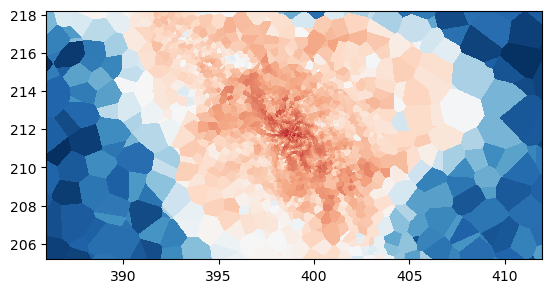

In [25]:
extent = slicer.extent.to('Mpc')

plt.imshow(slicer.slice_variable('0_Enstrophy').value,
           extent=extent.value,
           norm=LogNorm())

## Storing image data

The computing time for slices, and in particular, projections, is often quite long. It is therefore convenient to be able to store the image data so that this step is de-coupled from the often many matplotlib iterations.

Below we illustrate how to save an Arepo image, created using either a Projector or Slicer object.

In [26]:
image_file = pa.ArepoImage(slicer, basedir=pa.data_dir,
                           basename='test_arepo_image_format')

image_file.save_image('Density', slicer.slice_variable('0_Density'))
image_file.save_image('Enstrophy', slicer.slice_variable('0_Enstrophy'))

image_file.finalize()

The constructed file is found at:

In [27]:
image_file.filename

'/home/lena/analysis/paicos/data/test_arepo_image_format_247.hdf5'

## Reading image data and dealing with units

Now let's open this image and looks at its contents. We can use the ImageReader which is made to read additional info stored in image files: 

In [59]:
im = pa.ImageReader(basedir=pa.data_dir, snapnum=247, basename='test_arepo_image_format')
print(im.Config)
print(im.Header)
print(im.Parameters)
# print(im['Density'])
# print(im['Enstrophy'])

{'ADAPTIVE_HYDRO_SOFTENING': b'', 'ALLOW_DIRECT_SUMMATION': b'', 'BH_BONDI_DEFAULT': b'', 'BH_BUBBLES': b'', 'BH_DO_NOT_PREVENT_MERGERS': b'', 'BH_DRAG': b'', 'BH_PRESSURE_CRITERION': b'', 'BH_THERMALFEEDBACK': b'', 'BH_THERMALFEEDBACK_ACC': b'', 'BLACK_HOLES': b'', 'CELL_CENTER_GRAVITY': b'', 'CHUNKING': b'', 'COOLING': b'', 'DIRECT_SUMMATION_THRESHOLD': 10000.0, 'DOUBLEPRECISION': 1.0, 'DOUBLEPRECISION_FFTW': b'', 'DO_NOT_RANDOMIZE_DOMAINCENTER': b'', 'DRAINGAS': 1.0, 'ENFORCE_JEANS_STABILITY_OF_CELLS': b'', 'ENFORCE_JEANS_STABILITY_OF_CELLS_EEOS': b'', 'ENLARGEREGION': 1.1, 'ENLARGE_DYNAMIC_RANGE_IN_TIME': b'', 'EVALPOTENTIAL': b'', 'FIX_PATHSCALE_MPI_STATUS_IGNORE_BUG': b'', 'FOF': b'', 'FOF_PRIMARY_LINK_TYPES': 2.0, 'FOF_SECONDARY_LINK_TYPES': 49.0, 'GENERATE_GAS_IN_ICS': b'', 'GFM': b'', 'GFM_AGN_RADIATION': b'', 'GFM_BIPOLAR_WINDS': 1.0, 'GFM_COOLING_METAL': b'', 'GFM_NORMALIZED_METAL_ADVECTION': b'', 'GFM_OUTPUT_MASK': 127.0, 'GFM_SET_METALLICITY': b'', 'GFM_STELLAR_EVOLUTION':

Here 'Config', 'Header', 'Parameters' are groups copied over from the snapshot file used to create the image (.0.hdf5 when there are multiple files).

'Density' and 'Enstrophy' are 2D arrays saved images.

We can also access information about the slice originally made:

In [60]:
print(im.direction)
print(im.center)
print(im.extent)
print(im.widths)
print(im.npix)

z
[398968.40625 211682.59375 629969.875  ] arepo_length small_a / small_h
[385968.40625 411968.40625 205182.59375 218182.59375] arepo_length small_a / small_h
[26000. 13000.     0.] arepo_length small_a / small_h
1024


We can of course also use hdf5 to access this information. Specifically, the image information is stored in 'image_info':

In [61]:
import h5py
f = h5py.File(image_file.filename, 'r')
print(list(f.keys()))
print(f['image_info'].keys())
print(f['image_info'].attrs.keys())

['Config', 'Density', 'Enstrophy', 'Header', 'Parameters', 'image_info', 'org_info']
<KeysViewHDF5 ['center', 'extent', 'widths']>
<KeysViewHDF5 ['direction', 'image_creator']>


All required unit information is also saved in the image file:

In [57]:
dict(f['Density'].attrs)

{'unit': 'arepo_density small_h2 / small_a3'}

The advantage of using the ImageReader is that it helps with units!

We can use the ImageReader class to automatically get the image data in the form of PaicosQuantities (i.e. with units and in-built methods for manipulation). All the relevant information is stored in the image file, e.g.:

Text(0, 0.5, '$y\\;[\\mathrm{c}\\mathrm{Mpc}]$')

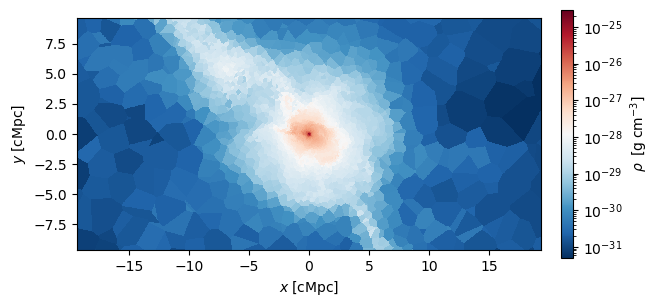

In [62]:

# Convert the extent to Mpc and get rid of the h factor
extent = im.centered_extent.to('Mpc').no_small_h #.to_physical

# Get rid of both a and h in the density
rho = im['Density'].to_physical

# Convert rho to typical astro units
rho = rho.astro

# Convert rho to cgs
rho = rho.cgs

# Plot the image
image = plt.imshow(rho.value, extent=extent.value, norm=LogNorm())

# Add a colorbar
cbar = plt.colorbar(image, fraction=0.025, pad=0.04)

# Set the labels. The units for the labels are here set using the .label method
# of the PaicosQuantity. This internally uses astropy functionality and is
# mainly a convenience function.
cbar.set_label(rho.label('\\rho'))
plt.xlabel(extent.label('x'))
plt.ylabel(extent.label('y'))

In [63]:
im.center
im.widths

<PaicosQuantity [26000., 13000.,     0.] arepo_length small_a / small_h>